# Modelling the precision of fixed point integer arithmetic

### References

https://stackoverflow.com/questions/783897/truncating-floats-in-python

In [1]:
import sys
sys.path.append("../venv/lib/python3.7/site-packages")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
DECIMALS = 18

UINT256_MAX = 2**256 - 1
UINT256_MAX

115792089237316195423570985008687907853269984665640564039457584007913129639935

In [3]:
def test_byte_overflow():
    counter = 0
    while counter < 256:
        print(counter)
        counter = byte(counter + 1)
        
def test_uint256_overflow():
    counter = 0
    while counter <= UINT256_MAX:
        print(counter)
        _counter = counter
        counter = uint256(counter + UINT256_MAX/10)
        assert(counter == _counter + UINT256_MAX/10)
        
def uint256_add(a, b):
    c = uint256(a + b)
    assert c == a + b, 'overflow'

def correct(value, bits, signed):
    value = int(float(truncate(value, 0)))
    _value = value
    base = 1 << bits
    value %= base
    result = value - base if signed and value.bit_length() == bits else value
    assert _value == result, 'overflow'
    return result

byte, sbyte, word, sword, dword, sdword, qword, sqword, uint256, int256 = (
    lambda v: correct(v, 8, False), lambda v: correct(v, 8, True),
    lambda v: correct(v, 16, False), lambda v: correct(v, 16, True),
    lambda v: correct(v, 32, False), lambda v: correct(v, 32, True),
    lambda v: correct(v, 64, False), lambda v: correct(v, 64, True),
    lambda v: correct(v, 256, False), lambda v: correct(v, 256, True),
)

In [4]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def sqrt(_x):
    _x = int(float(truncate(_x, 0)))
    _x = uint256(_x)
    if (_x == 0): return 0
    elif (_x <= 3): return 1
    
    z = uint256((_x + 1) / 2);
    y = uint256(_x);
    while z < y:
        y = uint256(z)
        z = uint256((_x / z + z) / 2)
    return y

In [5]:
int(float(truncate(10.0, 0)))

10

In [6]:
test_uint256_overflow()

0
11579208923731620185132316204464901002111835403029097412826955913908447084544
23158417847463240370264632408929802004223670806058194825653911827816894169088
34737626771194863769273037131375254090259690891412497282886855307311011856384
46316835694926480740529264817859604008447341612116389651307823655633788338176
57896044618658097711785492504343953926634992332820282019728792003956564819968
69475253542389714683041720190828303844822643053524174388149760352279341301760
81054462466121331654297947877312653763010293774228066756570728700602117783552
92633671389852948625554175563797003681197944494931959124991697048924894265344
104212880313584565596810403250281353599385595215635851493412665397247670747136
115792089237316182568066630936765703517573245936339743861833633745570447228928


AssertionError: overflow

In [7]:
sqrt(10)

3

In [8]:
sqrt(1000000000000000)

31622776

In [9]:
sqrt(UINT256_MAX)

AssertionError: overflow

In [10]:
sqrt(UINT256_MAX*2)

AssertionError: overflow

In [11]:
uint256_add(UINT256_MAX/3, UINT256_MAX/3)
uint256_add(UINT256_MAX/2, UINT256_MAX/2)

AssertionError: overflow

In [12]:
def curveIntegral(_x):
    _x = uint256(_x)
    assert _x >= 0, 'Input argument too small'
    #assert _x < 10**40, 'Input argument too large'

    # Calculate equation arguments
    x = _x*10**(DECIMALS - 18)
    x = uint256(x)
    a = 25*10**(DECIMALS - 6)
    a = uint256(a)
    b = 5*10**(DECIMALS - 1)
    b = uint256(b)

    # curve integral: (0.000025*x + 0.5)*x
    result = uint256(uint256(uint256(a*x)/(10**DECIMALS) + b)*x) / 10**DECIMALS
    return uint256(result)

In [13]:
curveIntegral(UINT256_MAX)

AssertionError: overflow

In [14]:
def inverseCurveIntegral(_x):
    _x = uint256(_x)
    assert _x >= 0, 'Input argument too small'
    #assert _x < 10**40, 'Input argument too large'

    # Use 36 decimal places for square root precision
    DECIMALS_36 = 36

    # Calculate equation arguments
    x = _x*10**DECIMALS
    x = uint256(x)
    prefix = 200*10**DECIMALS_36
    prefix = uint256(prefix)
    a = prefix*(sqrt(x + 2500*10**DECIMALS_36))/(sqrt(10**DECIMALS_36))
    a = uint256(a)

    # inverse curve integral: -10000 + 200*sqrt(x + 2500)
    result = uint256( int256(-10000*10**DECIMALS_36) + int256(a) ) / (10**DECIMALS)
    return uint256(result)

In [15]:
a = curveIntegral(100000000000000009999)
a

50250000000000008192

In [16]:
b = inverseCurveIntegral(a)
b

99999999999999066112

In [17]:
def save_experiment(fig, name):
    fig.savefig('%s.png' % name)

In [18]:
UINT256_MAX/1e58 - np.iinfo(int).max

2.355836886876844e+18

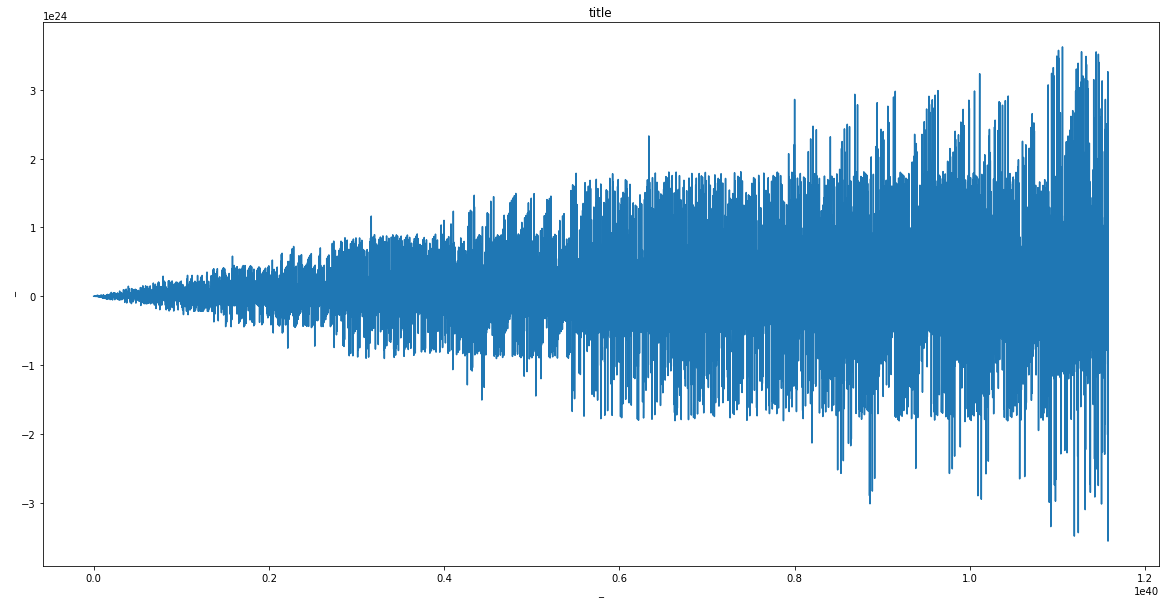

In [19]:
import mpmath

fig = plt.figure(1,figsize=(20,10))

x = range(0, int(UINT256_MAX/1e37), int(UINT256_MAX/1e37/10000))
a = [curveIntegral(_x) for _x in x]
b = [inverseCurveIntegral(_a) for _a in a]
c = np.subtract(x, b, dtype=object)

plt.plot(x, c)
plt.title('title')
plt.xlabel('_')
plt.ylabel('_')

fig.savefig('variance.png')

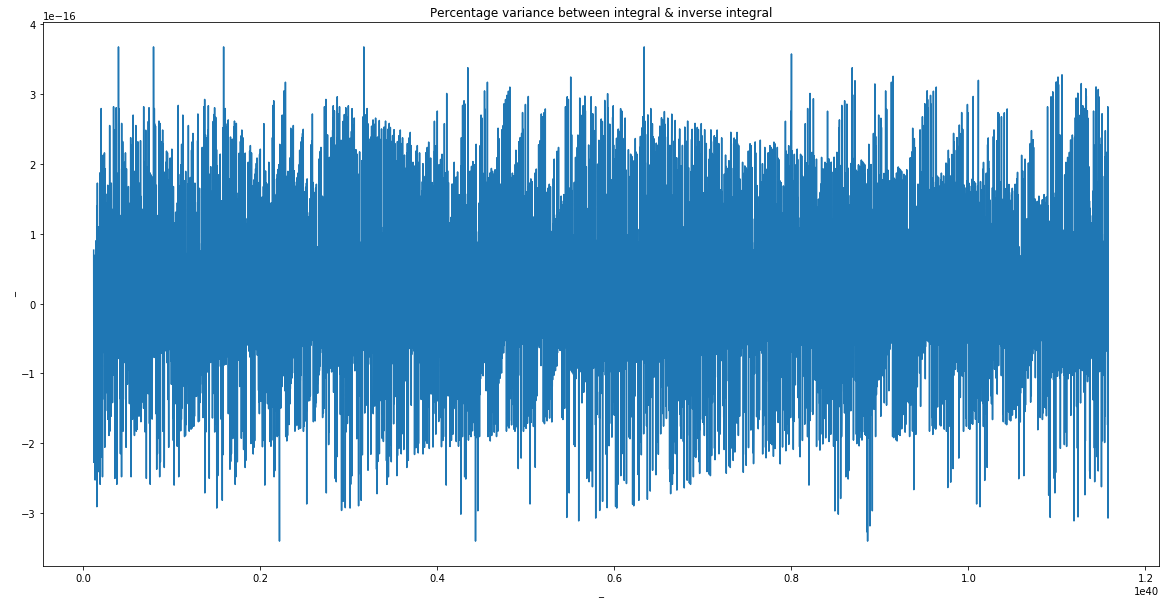

In [20]:
fig = plt.figure(2,figsize=(20,10))

y = [_c/_x for _c,_x in zip(c[100:],x[100:])]

plt.plot(x[100:], y)
plt.title('Percentage variance between integral & inverse integral')
plt.xlabel('_')
plt.ylabel('_')

fig.savefig('percent_variance.png')

In [21]:
max(y)

3.674359355266896e-16

In [22]:
from scipy.io.wavfile import write
from scipy.interpolate import UnivariateSpline

# data = np.random.uniform(-1,1,44100) # 44100 random samples between -1 and 1
scaled = np.int16(y/np.max(np.abs(y)) * 32767)
write('test.wav', 44100, scaled)